# 02805 Social graphs and interactions: Assignment 2
Authored by:
- s194574, Max Heiberg Bestle
- s232755, Ioannis Vlasakoudis
- s183649, Jonatan Rasmussen  
  
Due on Tuesday November 5th, 2024 at 23:55

## Part 1: Genres and communities and plotting 

This part of the assignment covers the following exercises:
> * Write about genres and modularity.
> * Detect the communities, discuss the value of modularity in comparison to the genres.
> * Calculate the matrix $D$ and discuss your findings.
>* Plot the communities and comment on your results.

In part 1, we will be analyzing the genres and communities of the country musicians network. We will be looking at the modularity of the network first, trying to partition the network correctly.

First, what is modularity? Modularity is a measure used to see how community-like a network, or part of a network, is. We calculate it by looking at the network's edges and nodes, and seeing which communities they belong to. The modularity can then tell us to what degree the network can be partitioned into communities, and whether or not there is a community-like pattern in the network. We calculate it using this equation:

$M = \sum_{c=1}^{n_{c}} [\frac{L_c}{L} - (\frac{k_c}{2L})^2]$

where $c$ is the current community, $n_c$ is the amount of communities, $L_c$ is the amount of links in the community, $L$ is the amount of links in the whole network, and $k_c$ is the average degree of the community.

As we've now explained the modularity measure, let's start setting up the network and laying the groundwork to calculate the modularity.

First we need to gather all the genres together for all the performers. Luckily, we've received a txt file containing this information, where each performer has a list of genres from their wikipedia articles.

In [34]:
import json
import re
import os
import networkx as nx
import unicodedata
all_genres_file = open("artists_genres_dictionary.txt",encoding='utf-8')
all_genres = json.load(all_genres_file)

We can now create the network, remembering to sanitize the titles for txt files. We want to check if we have the genres for each performer, otherwise we can simply skip that performer:

In [35]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)
        #Add as a node, containing the length of the article and their first genre as characteristics
        G_country.add_node(file_title_san,length_of_content=content_length,genre = all_genres[performer_name][0])
        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We've now created the network. We can then try to do our own partitioning of the network, based on genres:

In [36]:
genre_partition = {}
genres = nx.get_node_attributes(G_undir,"genre")
for node, data in G_undir.nodes(data=True):
    genre = data['genre']  # First genre in the performer's list
    if genre not in genre_partition:
        genre_partition[genre] = []
    genre_partition[genre].append(node)

Let's now try to calculate the modularity using our partition:

In [ ]:
communities = list(genre_partition.values())
def modularity_measure(G_undir, communities):
    L = G_undir.size()
    modularity = 0
    for community in communities:
        G_community = G_undir.subgraph(community)
        L_c = G_community.size()
        k_c = sum(dict(G_undir.degree(community)).values())
        modularity += (L_c/L) - (k_c/(2*L))**2
    return modularity

print(modularity_measure(G_undir,communities))


0.07061860613048114


Here we can see that the modularity is positive but not very high, meaning not a lot of modularity or community structure. Currently, most of the artists are country artists, so let's try choosing their second genre instead.

In [ ]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)

        # Add as a node, containing the length of the article and their SECOND genre as characteristics
        #Default to first genre if there isn't enough genres
        performer_genre = all_genres[performer_name][0]
        if "country" in all_genres[performer_name] and len(all_genres[performer_name]) > 1:
            for genre in all_genres[performer_name]:
                if genre != "country":
                    performer_genre = genre
        G_country.add_node(file_title_san,length_of_content=content_length,genre = performer_genre)

        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We can try to calculate the modularity again, after partitioning:

In [ ]:
genre_partition = {}
genres = nx.get_node_attributes(G_undir,"genre")
for node, data in G_undir.nodes(data=True):
    genre = data['genre'] #Second genre in genre list
    if genre not in genre_partition:
        genre_partition[genre] = []
    genre_partition[genre].append(node)
communities = list(genre_partition.values())
print(modularity_measure(G_undir,communities))

0.06465620807739869


This is positive modularity, but still not a very high modularity, meaning the partition is sub-optimal, and we can't correctly find communities based on the genre partitioning. In fact, the modularity is lower than before. This might show that by choosing the second genre, more nodes are "isolated", since they might be the only ones with that genre, thus creating more isolated, smaller communities and a lower modularity.

We can see that the partitioning based on the genres didn't really show much modularity. We can try to use the Python Louvain-algorithm implementation to try and obtain a better partitioning:

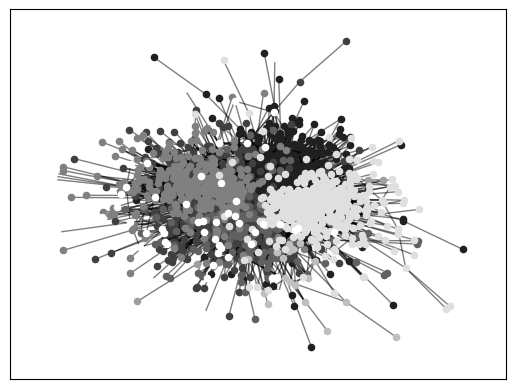

In [40]:
import community
import networkx as nx
import matplotlib.pyplot as plt
G_undir = G.to_undirected()
partition = community.best_partition(G_undir)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_undir)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G_undir, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G_undir,pos, alpha=0.5)
plt.show()

What is the modularity of this partitioning? The community package has it's own modularity function, which we can use:

In [41]:
community.modularity(partition,G_undir)

0.38784058048326225

The modularity is much higher here, showing that there is some kind of community patterns in the network, not necessarily based entirely on genre, but some other elements of the network. This could be social grouping, where people group together if they know each other. What we see is a network that is more community-like than the genre partioning showed. 

Plotting the network with these communities, using ForceAtlas2, can show us how well this modularity and partitioning represents the network:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 21.05it/s]


BarnesHut Approximation  took  17.52  seconds
Repulsion forces  took  74.19  seconds
Gravitational forces  took  0.26  seconds
Attraction forces  took  0.58  seconds
AdjustSpeedAndApplyForces step  took  1.13  seconds


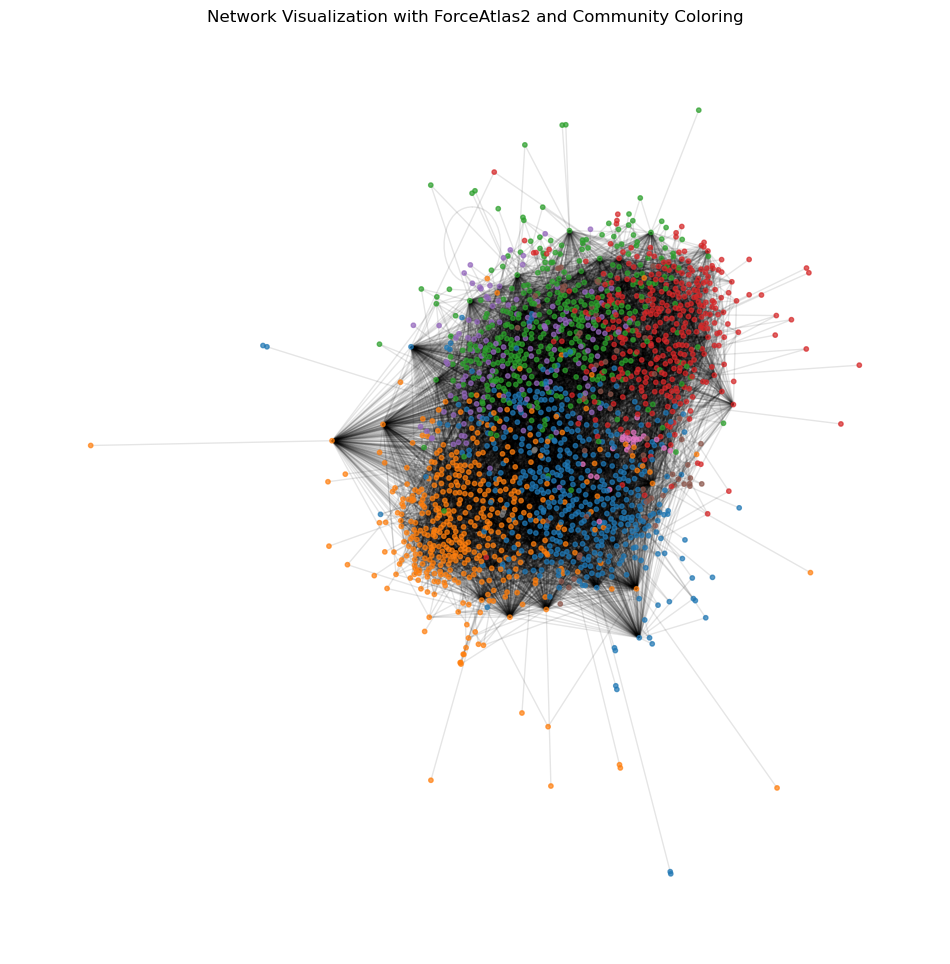

In [42]:
from fa2_modified import ForceAtlas2
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=2000)

community_sizes = {}
for node, com in partition.items():
    if com not in community_sizes:
        community_sizes[com] = 0
    community_sizes[com] += 1

top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)
colors = list(mcolors.TABLEAU_COLORS.keys())
community_color_map = {com: colors[i % len(colors)] for i, com in enumerate(top_communities)}
neutral_color = "lightgray"

node_colors = [
    community_color_map.get(partition[node], neutral_color) for node in G_undir.nodes()
]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_undir, positions, node_color=node_colors, node_size=10, alpha=0.7)
nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.1)

plt.title("Network Visualization with ForceAtlas2 and Community Coloring")
plt.axis("off")
plt.show()

We can see that each "corner" of the structure is its own big community, meaning we have 4 big communities. There are also small communities mixed in within the structure. These smaller communities have some level of structure, either by closeness or some links connecting them across the network. For example, one of the communities is spacially mixed, having nodes of two communities next to each other. These may link together in ways, causing them to be partitioned into two different communities, even though they positionally are closer to each other.

We've now looked at what happens if we only choose one genre. What if we choose the full list for each performer, and try to make a confusion matrix out of the network?

In [ ]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)

        #Add the performer as node, with content length and list of genres as characteristics
        performer_genre = all_genres[performer_name]
        G_country.add_node(file_title_san,length_of_content=content_length,genre = performer_genre)

        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We can now try to construct the confusion matrix, for the top 7 genres and communities:

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import community
import networkx as nx
import matplotlib.pyplot as plt

partition = community.best_partition(G_undir)

node_genres = nx.get_node_attributes(G_undir,"genre")
all_genres = [genre for genres in node_genres.values() for genre in genres]

# Step 1: Identify the top 7 genres and top 7 communities
genre_counts = Counter(all_genres)
top_genres = [genre for genre, _ in genre_counts.most_common(7)]

community_counts = Counter(partition.values())
top_communities = [community for community, _ in community_counts.most_common(7)]

# Create mappings for genre and community indices
genre_to_index = {genre: i for i, genre in enumerate(top_genres)}
community_to_index = {community: j for j, community in enumerate(top_communities)}

# Step 2: Initialize the confusion matrix D with dimensions 7x7
D = np.zeros((7, 7), dtype=int)

# Step 3: Populate the confusion matrix
for node, genres in node_genres.items():
    community = partition.get(node)

    if community in community_to_index:
        j = community_to_index[community]
        # Check if the node's genre and community are in the top 7
        for genre in genres:
            if genre in genre_to_index:
                i = genre_to_index[genre]
                D[i, j] += 1

# Convert the matrix to a DataFrame for easier viewing
confusion_df = pd.DataFrame(D, index=top_genres, columns=top_communities)

# Display the confusion matrix
print("Confusion Matrix (Genre vs Community):")
print(confusion_df)


Confusion Matrix (Genre vs Community):
                1    2    5    4   0   3  6
country       462  352  359  172  84  53  6
folk           19   10   29   88  31   1  0
country rock   33   48   21   53   5   4  6
americana      20   12   14   88  16   1  5
pop            26   51   45   24   4   3  0
bluegrass      24    9    8   21  65   0  0
rock           23   20   18   44   6   3  1


We can see that the communities don't really correspond to genres. Most of them seem to have country music as the most popular genre, which makes sense, as this is a network of country performers. Even the second most popular genre doesn't really give us a direction for each community, as they are very close.

This might show us that within these genres, communities have shaped differently. Perhaps this might be groups that collaborate often, or are more inspired by each other, than other parts of the network, thus creating a community based partly on genres but also on the social aspect of which performers perform with each other or are inspired across groups.

## Part 2: TF-IDF to understand genres and communities 

This part of the assignment covers the following exercises:
> * Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
> * Calculate and visualize TF-IDF for the genres and communities.
> * Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


### Part 2A
* The concept of TF-IDF

TF-IDF is a measure, which can be a very useful tool for text analysis if it is used correctly. While normal Term Frequency can give us some insights about a text (after excluding common words such as a/an, the, is, are, etc), in our case it may not be so useful when we compare different communities or when we want to understand what is special about a community. Implementing TF-IDF can help us understand the context of genres and communities better, since this measure gives a higher weight to words that appear in fewer genres/communities. Thus, we can identify significant words or key terms that are common in the performers' wikipage for each genre and recognize what is important about a genre or how the performers of a certain genre are connected. For example, maybe there is a specific word that is used a lot only in the genre of country music, like a trademark word and so it appears as one of the top words based on the TF-IDF score and that can seperate this community from another.

### Part 2B
* Calculate and visualize TF-IDF for the genres and communities.


We start by improrting the file with the performers and their wikitext from the previous assignment and the file with the genres. Regarding the genre file, we just have to change a bit the performers' names, so that they are in the same format as the other file. We are doing that, because later on we want to be able to identify which performers are in both of the files.

In [ ]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
import matplotlib.pyplot as plt
import re
import networkx as nx
from urllib.parse import quote
import matplotlib as mpl
import numpy as np
import pandas as pd
import json
import string
import community
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix


with open("performer_text.json", "r") as f:
    performer_text = json.load(f)

with open("genre.txt", "r") as f:
    genre = json.load(f)

updated_genre = {}

for key, value in genre.items():
    new_key = key.replace(" ", "_").replace("\\", "")
    updated_genre[new_key] = value

updated_genre

{'A_Thousand_Horses': ['country', 'country rock', 'southern rock'],
 'A.P._Carter': ['country', 'folk', 'gospel'],
 'Aaron_Barker': ['country'],
 'Aaron_Benward': ['country', 'christian music'],
 'Aaron_Lewis_(musician)': ['alternative metal',
  'post-grunge',
  'nu metal',
  'country rock',
  'alternative country'],
 'Aaron_Lines': ['country'],
 'Aaron_Neville': ['soul', 'country', 'gospel', 'jazz', 'pop'],
 'Aaron_Pritchett': ['country'],
 'Aaron_Watson': ['country', 'red dirt', 'texas country'],
 'Ace_in_the_Hole_Band': ['alternative country',
  'neotraditional country',
  'western swing'],
 'Adam_Brand_(musician)': ['country'],
 'Adam_Gregory': ['country music'],
 'Adam_Harvey': ['country'],
 'Adrienne_Young': ['bluegrass',
  'country',
  'old-time music',
  'american folk music'],
 'Al_Anderson_(NRBQ)': ['rock', 'country'],
 'Al_Caiola': ['jazz', 'country', 'rock', 'pop'],
 'Al_Dexter': ['country'],
 'Al_Downing_(musician)': ['rockabilly',
  'rock and roll',
  'blues',
  'rhythm a

From the genre file we only need the first genre from each performer.

In [ ]:
for performer, genres in updated_genre.items():
    if genres:
        updated_genre[performer] = [genres[0]]

Let's create again the communities using the Louvain method, since it was the one with the highest modularity. 

In [34]:
common_performers = set(performer_text.keys()).intersection(updated_genre.keys())

performer_contents = {}

for performer, content in performer_text.items():
    if performer in common_performers:
        performer_contents[performer] = re.findall(r"\[\[(.*?)\]\]", content)

for performer, links in performer_contents.items():
    new_values = [link.replace(" ", "_").replace("\\", "") for link in links]
    performer_contents[performer] = new_values

matches = []

for performer, links in performer_contents.items():
    for link in links:
        if link in performer_contents:
            matches.append((performer, link))

matches = list(set(matches))

G = nx.DiGraph()
G.add_nodes_from(performer_contents.keys())
G.add_edges_from(matches)

isolated = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(isolated)

largest_component = max(nx.weakly_connected_components(G), key=len)
D = G.subgraph(largest_component).copy()

D_undir = D.to_undirected()

partition = community.best_partition(D_undir)

As we can see the communities are split more evenly compared to the genres, where country represents the majority in genres.

In [35]:
community_performer_counts = Counter(partition.values())

community_counts_df = pd.DataFrame(community_performer_counts.items(), columns=['Community', 'Number of Performers'])

print(community_counts_df.to_string(index=False))

 Community  Number of Performers
         0                   438
         1                   336
         2                    89
         3                   430
         8                    79
         9                    60
         6                   133
         4                     5
         5                     5
         7                     2


Then, we proceed with the preperation of the text for the TF-IDF scores (only for the performers that appear in both files). Thus, we first group the texts from each performer into one big single string. Afterwards, we proceed with the tokenization, which splits these strings into individual words. Finally, we convert each word to lowercase and remove stopwords. We also excluded the words "ref", "cite", "pageid" and "n", which are words we could not clear from the original json file and are very common in every performer's text. And to make things more simple, we performed lemmatization on the words and did not take into account rare words that appear less than 5 times.

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

stop_words = set(stopwords.words('english')) | {'ref', 'cite', 'pageid', 'n', 'ref', 'date', 'com', 'url', 'title', 'web',
    'www', 'http', 'https', 'archive', 'width', 'align',
    'center', 'scope', '01', 'album', 'band', 'english',
    'access', 'category', 'org'}

genre_documents = {}
genre_text = {}

for performer, text in performer_text.items():
    if performer in updated_genre:
        genre = updated_genre[performer][0]
        if genre not in genre_documents:
            genre_documents[genre] = []
        genre_documents[genre].append(text)

for genre, texts in genre_documents.items():
    combined_text = ' '.join(texts)
    tokens = nltk.word_tokenize(combined_text)

    tokens = [word.lower() for word in tokens if word.isalpha()]

    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    word_counts = Counter(tokens)

    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= 5}

    genre_documents[genre] = filtered_word_counts
    genre_text[genre] = tokens

for genre, word_counts in genre_documents.items():
    print(f"Genre: {genre}")
    print("Word Frequencies:", word_counts)

Genre: alternative country
Word Frequencies: {'n': 24, 'ace': 11, 'hole': 15, 'revision': 24, 'contentformat': 24, 'contentmodel': 24, 'wikitext': 24, 'short': 38, 'country': 403, 'music': 316, 'performer': 34, 'george': 27, 'strait': 31, 'infobox': 27, 'musical': 81, 'name': 74, 'image': 28, 'caption': 22, 'alias': 12, 'origin': 21, 'san': 25, 'marcos': 5, 'texas': 138, 'united': 31, 'genre': 38, 'alternative': 97, 'western': 17, 'swing': 17, 'label': 115, 'record': 221, 'mca': 10, 'website': 38, 'terry': 12, 'mike': 36, 'daily': 15, 'ron': 10, 'rick': 14, 'benny': 7, 'joe': 36, 'john': 59, 'michael': 13, 'marty': 8, 'wes': 6, 'david': 29, 'anthony': 9, 'ted': 8, 'tommy': 9, 'foote': 7, 'jay': 29, 'bill': 15, 'roger': 8, 'jeff': 64, 'thom': 5, 'gene': 7, 'american': 214, 'lead': 44, 'singer': 100, 'solo': 48, 'career': 34, 'early': 40, 'formed': 29, 'recorded': 68, 'several': 26, 'single': 54, 'including': 36, 'ca': 12, 'go': 17, 'like': 37, 'want': 16, 'talk': 17, 'king': 76, 'group'

Then we do the same preparation for the communities.

In [ ]:
stop_words = set(stopwords.words('english')) | {'ref', 'cite', 'pageid', 'n', 'date', 'contentformat', 'contentmodel'
    'com', 'url', 'title', 'web', 'www', 'http', 'https', 'wikitext', 'short',
    'archive', 'width', 'align', 'center', 'scope', '01',
    'album', 'band', 'english', 'access', 'category', 'org'}


community_documents = {}
community_text = {}

for performer, community_id in partition.items():
    if performer in performer_text:
        text = performer_text[performer]
        if community_id not in community_documents:
            community_documents[community_id] = []
        community_documents[community_id].append(text)

for community_id, texts in community_documents.items():
    combined_text = ' '.join(texts)
    tokens = nltk.word_tokenize(combined_text)

    tokens = [word.lower() for word in tokens if word.isalpha()]

    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    word_counts = Counter(tokens)

    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= 5}

    community_documents[community_id] = filtered_word_counts
    community_text[community_id] = tokens

for community_id, word_counts in community_documents.items():
    print(f"Community: {community_id}")
    print("Word Frequencies:", word_counts)

Community: 0
Word Frequencies: {'n': 439, 'ace': 55, 'hole': 65, 'revision': 438, 'contentmodel': 438, 'country': 12113, 'music': 7445, 'performer': 331, 'george': 770, 'strait': 382, 'infobox': 524, 'musical': 1277, 'name': 1160, 'image': 565, 'caption': 362, 'hartford': 15, 'connecticut': 15, 'alias': 187, 'stoney': 31, 'origin': 230, 'san': 249, 'marcos': 14, 'texas': 1498, 'united': 1061, 'genre': 591, 'alternative': 54, 'neotraditional': 29, 'western': 597, 'swing': 222, 'label': 1721, 'record': 4853, 'mca': 270, 'website': 487, 'terry': 61, 'hale': 6, 'mike': 101, 'daily': 128, 'ron': 45, 'rick': 93, 'benny': 41, 'joe': 405, 'manuel': 6, 'john': 775, 'michael': 139, 'marty': 203, 'wes': 11, 'david': 350, 'anthony': 51, 'ted': 31, 'tommy': 106, 'foote': 7, 'jay': 57, 'bill': 501, 'roger': 177, 'montgomery': 155, 'jeff': 68, 'thom': 58, 'flora': 6, 'kennedy': 78, 'gene': 262, 'backup': 51, 'american': 3769, 'lead': 432, 'singer': 2402, 'beginning': 141, 'solo': 473, 'career': 1051,

Now, we are ready to calculate the TF-IDF scores for the words. For this we are using the TfidfVectorizer from the sklearn library. The formula that this function uses to calculate the IDF is the following:
$$
\text{idf}(t) = \log \left( \frac{1 + N}{1 + \text{df}(t)} \right) + 1
$$


Beginning with the genres, below is an example of the TF-IDF scores for the top 10 words in Alternative Country Genre. We can notice that Tweedy has the highest score, and after a research, we found that his work has left a significant mark on the landscape of alternative rock, so it is normal to be mentioned a lot in the texts of performers form alternative rock. There are also the names of other popular alternative rock artists in this top 10 list, and many music related words that are common across all genres, but their high TF-IDF scores are probably driven by their frequent use in this text.

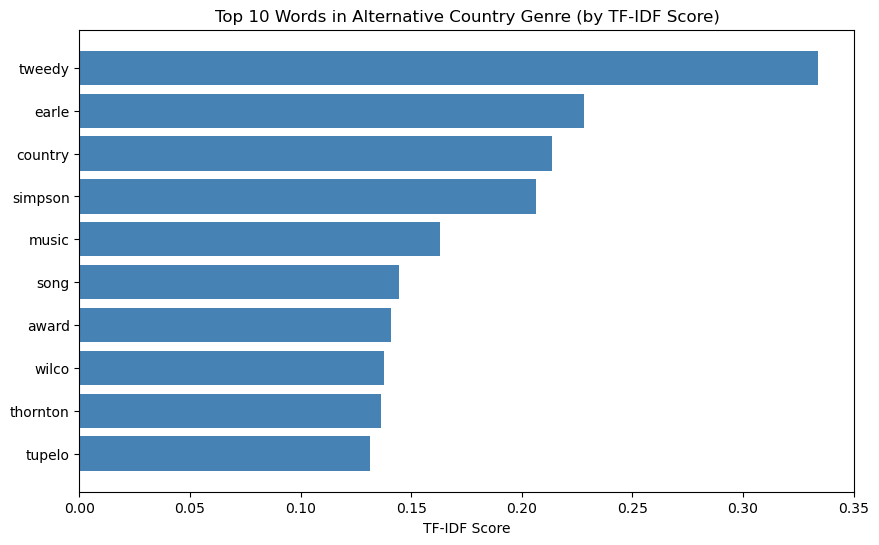

In [ ]:
genre_documents_single = {genre: ' '.join(texts) for genre, texts in genre_text.items()}
genres = list(genre_documents_single.keys())
documents = list(genre_documents_single.values())

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=genres)

words_number = 10
top_words = tfidf_df.loc['alternative country'].nlargest(words_number)

plt.figure(figsize=(10, 6))
plt.barh(top_words.index, top_words.values, color='steelblue')
plt.xlabel('TF-IDF Score')
plt.title('Top 10 Words in Alternative Country Genre (by TF-IDF Score)')
plt.gca().invert_yaxis()
plt.show()

Regarding the communities, the results are not so clear as the genres. We can see that in communities 4 and 7 there are some words with high TF-IDF scores but that is because there are only 5 and 2 performers respectively in these communities, while in community 2 we can see that there are no key words that characterize this community, since most of the top words have the same score. The same as community 2 applies in every other community with a high number of performers in it. 

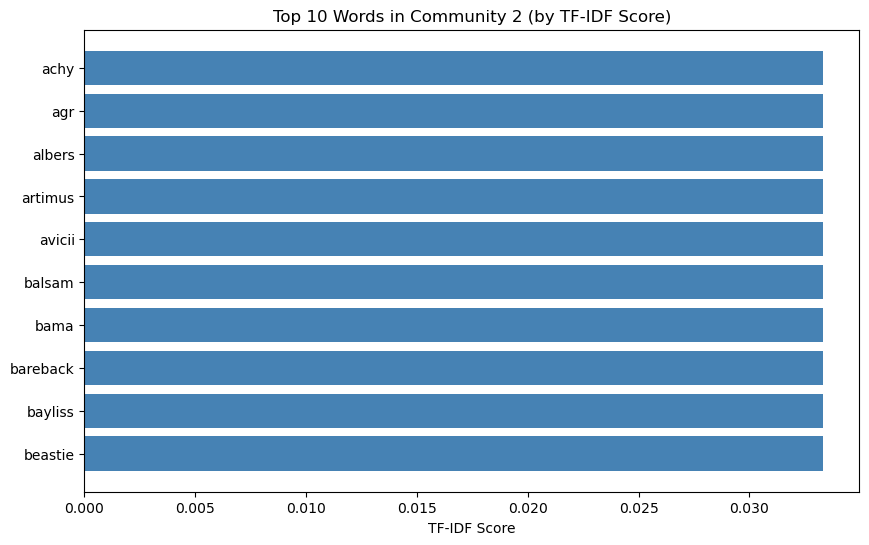

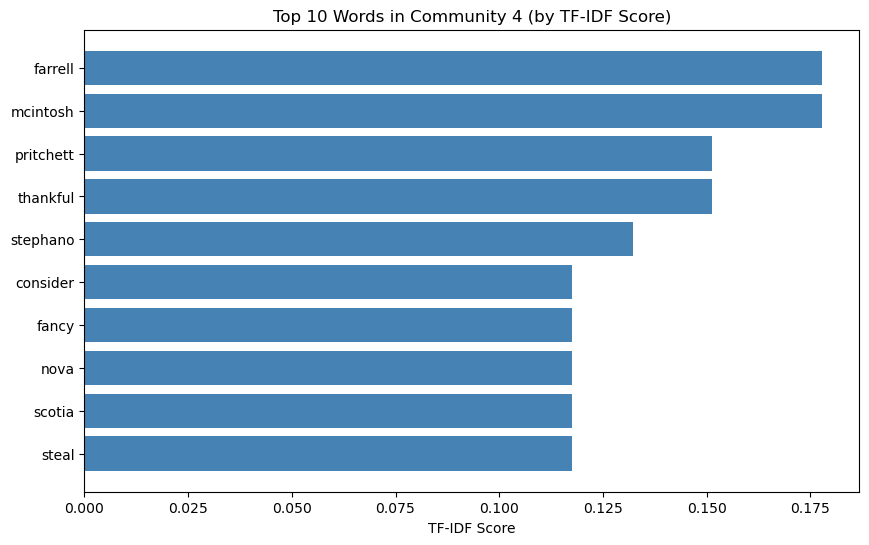

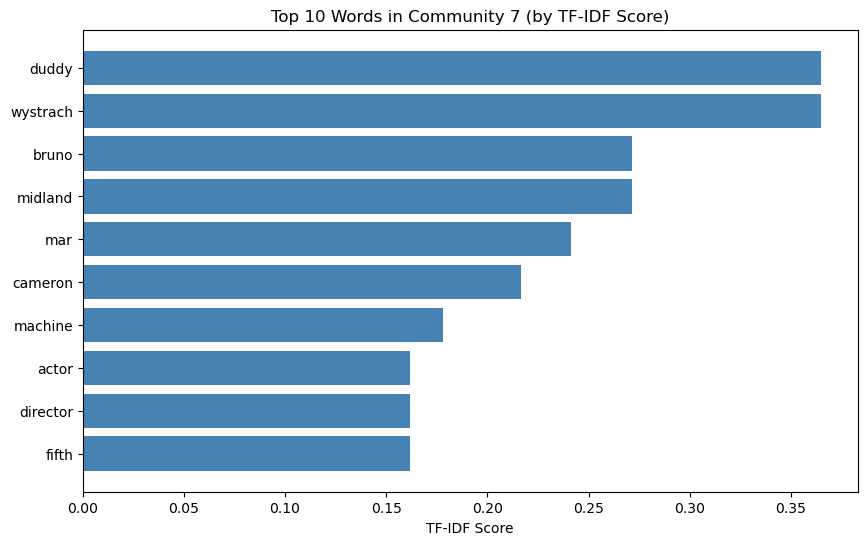

In [46]:
community_documents_single = {community_id: ' '.join(texts) for community_id, texts in community_documents.items()}
communities = list(community_documents_single.keys())
documents_com = list(community_documents_single.values())

vectorizer_com = TfidfVectorizer()
tfidf_matrix_com = vectorizer_com.fit_transform(documents_com)

tfidf_df_com = pd.DataFrame(tfidf_matrix_com.toarray(), columns=vectorizer_com.get_feature_names_out(), index=communities)

communities_of_interest = [2, 4, 7]
words_number_com = 10

for community in communities_of_interest:
    top_words_com = tfidf_df_com.loc[community].nlargest(words_number_com)
    plt.figure(figsize=(10, 6))
    plt.barh(top_words_com.index, top_words_com.values, color='steelblue')
    plt.xlabel('TF-IDF Score')
    plt.title(f'Top {words_number_com} Words in Community {community} (by TF-IDF Score)')
    plt.gca().invert_yaxis()
    plt.show()

Here we plot the wordclouds for the top 15 genres. Again, like alternative country genre, the majority of the genres is mainly characterized by performers who are important for each one and musical terms that are likely to be used a lot in these type of texts.

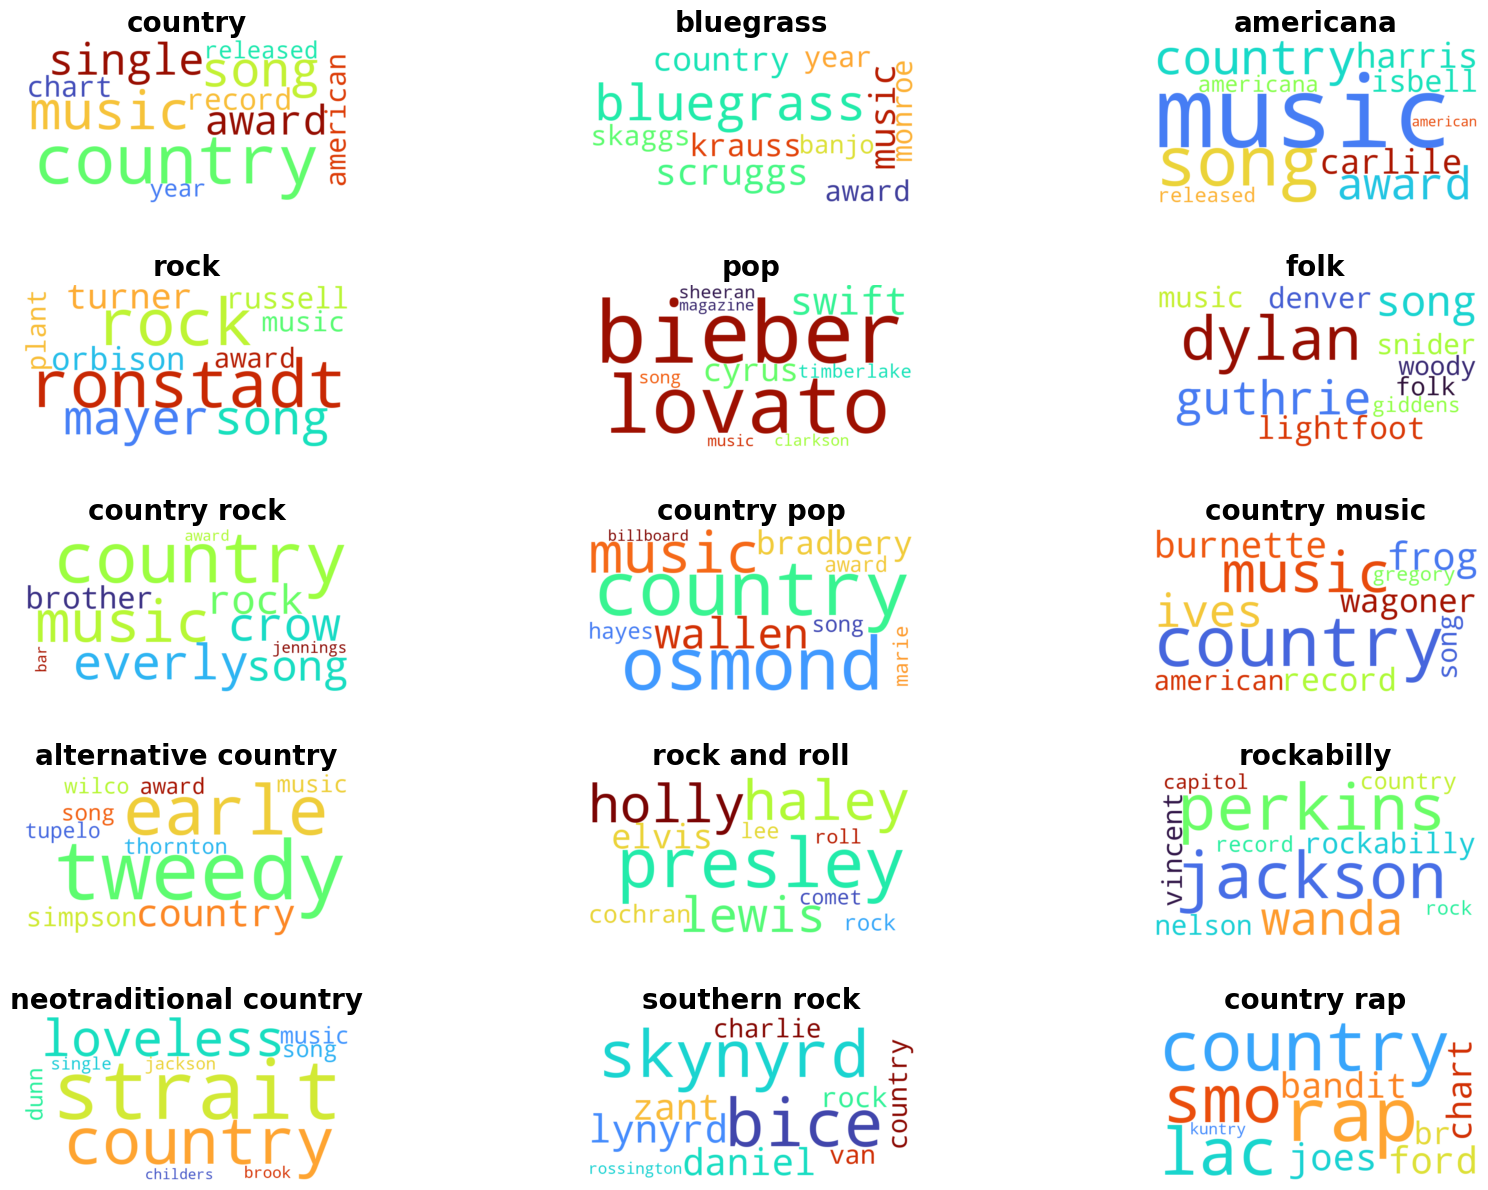

In [ ]:
genre_counts = Counter([genres[0] for genres in updated_genre.values() if genres])
top_15_genres = [genre for genre, counts in genre_counts.most_common(15)]
filtered_tfidf_df = tfidf_df.loc[top_15_genres]

def plot_genre_wordclouds(tfidf_df, n=10):
    plt.figure(figsize=(18, 12))

    for i, genre in enumerate(tfidf_df.index):
        top_words = tfidf_df.loc[genre].nlargest(n)

        word_scores = dict(top_words)

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='turbo', collocations=False).generate_from_frequencies(word_scores)

        plt.subplot(5, 3, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(genre, fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_genre_wordclouds(filtered_tfidf_df, words_number)

And for the communities as we said previously, there are not many keywords that set one community apart from another.

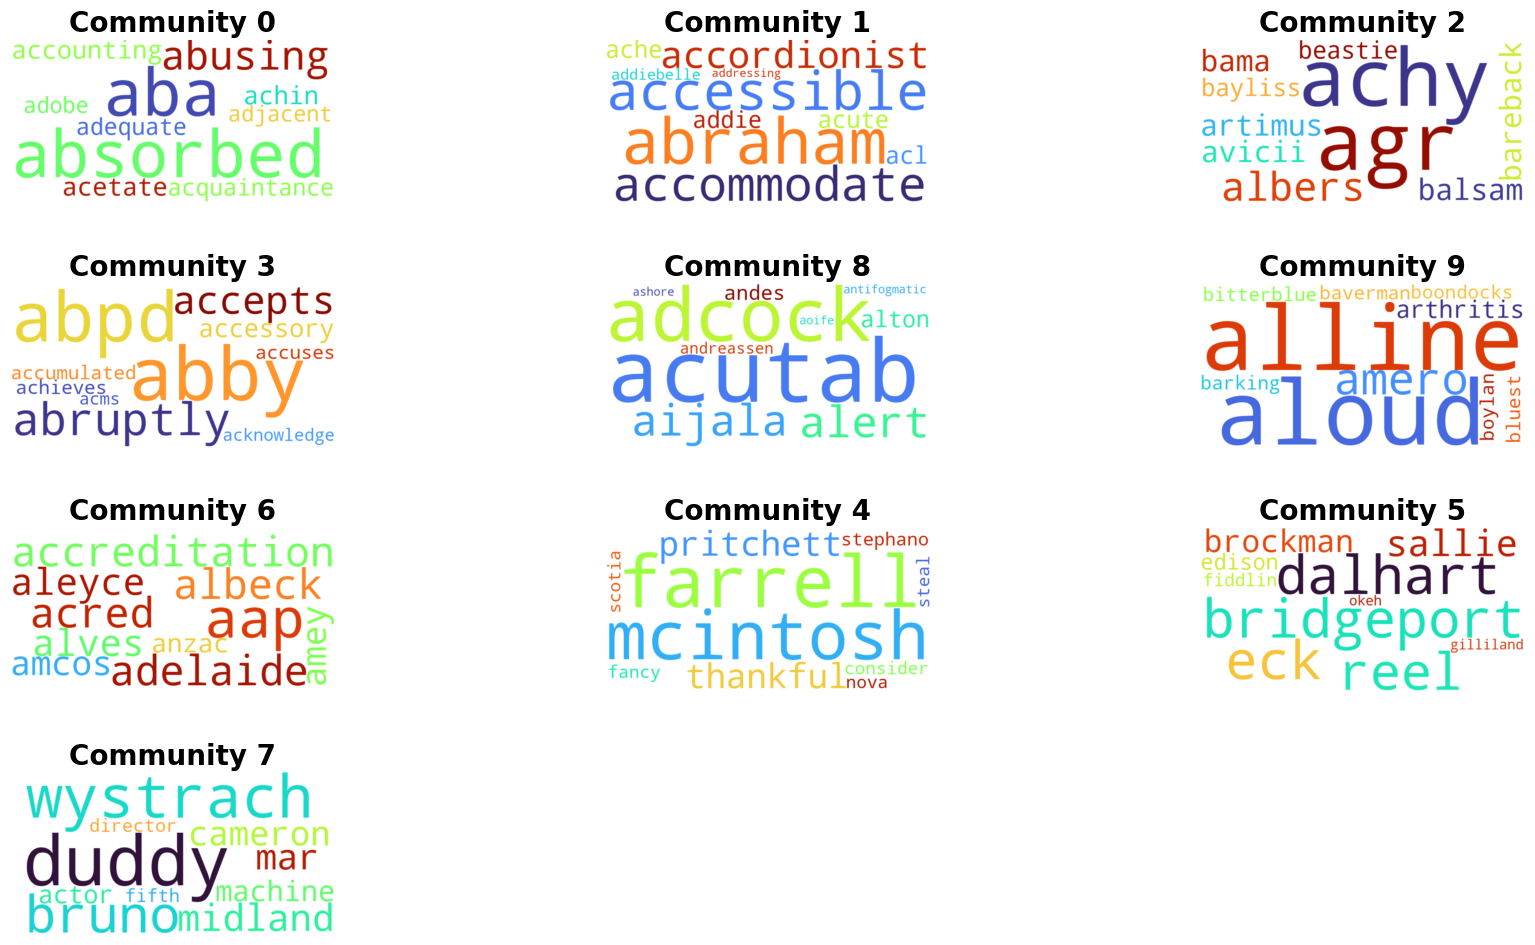

In [ ]:
community_counts = Counter([community_id for community_id in community_documents.keys()])
top_15_communities = [community for community, counts in community_counts.most_common(15)]
filtered_tfidf_df_com = tfidf_df_com.loc[top_15_communities]

def plot_community_wordclouds(tfidf_df_com, n=10):
    plt.figure(figsize=(18, 12))

    for i, community in enumerate(tfidf_df_com.index):
        top_words = tfidf_df_com.loc[community].nlargest(n)

        word_scores = dict(top_words)

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='turbo', collocations=False).generate_from_frequencies(word_scores)

        plt.subplot(5, 3, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Community {community}', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_community_wordclouds(filtered_tfidf_df_com, words_number)

### Part 2C
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.



As we can see in the matrix D from part 1 and the word-clouds between genres and communities, it is not so clear that each community can represent one genre of music. In the comparison between the word-clouds between genres and communities, we can notice some words with a relatively high TF-IDF scores in communities word-clouds, but it cannot be directly associated with a word-cloud from the genres.

Now, let's look at the matrix D between the top 7 genres and communities, where we will see the common words between them. We start by selecting the 7 most common communities and genres.

In [51]:
community_counts = Counter(partition.values())
most_common_communities = community_counts.most_common(7)
top_7_community_ids = [community_id for community_id, count in most_common_communities]
top_7_community_documents = {community_id: community_documents_single[community_id] for community_id in top_7_community_ids if community_id in community_documents_single}

top_7_genre_names = [genre for genre, count in genre_counts.most_common(7)]
top_7_genre_documents = {genre: genre_documents_single[genre] for genre in top_7_genre_names if genre in genre_documents_single}

Then we can proceed to the confusion matrix.

In [ ]:
def tokenize(text):
    return set(text.lower().split())

genre_word_sets = {genre: tokenize(content) for genre, content in top_7_genre_documents.items()}
community_word_sets = {community: tokenize(content) for community, content in top_7_community_documents.items()}

all_words = set()
for words in genre_word_sets.values():
    all_words.update(words)

for words in community_word_sets.values():
    all_words.update(words)

word_index = {word: idx for idx, word in enumerate(all_words)}

confusion_mat = np.zeros((len(top_7_genre_documents), len(top_7_community_documents)))

for i, (genre, genre_words) in enumerate(genre_word_sets.items()):
    for j, (community, community_words) in enumerate(community_word_sets.items()):
        common_words = genre_words.intersection(community_words)
        confusion_mat[i, j] = len(common_words)

confusion_df = pd.DataFrame(confusion_mat,
                            index=top_7_genre_documents.keys(),
                            columns=top_7_community_documents.keys())

print(confusion_df)

                   0       3       1       6       2       8       9
country       8515.0  7704.0  8054.0  2468.0  2480.0  2244.0  2487.0
bluegrass     4320.0  3883.0  4372.0  1862.0  1949.0  2143.0  1972.0
americana     4974.0  4603.0  5492.0  1976.0  2091.0  2007.0  2133.0
rock          6095.0  5509.0  6204.0  2108.0  2250.0  2003.0  2361.0
pop           6129.0  6178.0  6070.0  2111.0  2213.0  1972.0  2309.0
folk          5043.0  4545.0  5510.0  1958.0  2031.0  1967.0  2134.0
country rock  3998.0  3806.0  4027.0  1861.0  2047.0  1742.0  1975.0


We can notice that again there is not a clear pattern between the genres and communities. Most of the common words appear between the genres and the communities 0, 1 and 3 which are the communities with the most performers in them. But the numbers in these 3 communities are once more evenly split, just like the confusion matrix with the number of common performers.

## Part 3: Sentiment Analysis of the Country Music Network

This part covers the sentiment analysis of the country music network, addressing two main questions:
> * Calculate and analyze the sentiment of the Artists pages
> * Discuss the sentiment of the largest communities


### Initial Setup and Data
Dear reader, feel free to skip this entire setup section! You can scroll down to the big header reading *"Part 3A: Sentiment Analysis of Artist Pages"* without missing anything important. This section is only included in the notebook for code documentation purposes.  
  
(Initial setup step 1 of 3): First we will import the necessary libraries and load our data.

In [ ]:
#Only run these initial setup cells once as it takes an hour or so to fully execute...
for name in dir():  #Remove all variable declarations from Part1 and Part2
    if not name.startswith('_'):
        del globals()[name]  #Wipe memory
import pandas as pd, numpy as np, pickle, json, re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import networkx as nx, community
import urllib3, requests
from urllib.parse import quote

(Initial setup step 2 of 3):  We fetch data from wikipedia (done as part of previous exercises. This takes roughly an hour)

In [ ]:
def fetch_country_musicians():
    http = urllib3.PoolManager()
    baseurl = "https://en.wikipedia.org/w/api.php?"
    query = f"{baseurl}action=query&titles=List_of_country_music_performers&prop=revisions&rvprop=content&format=json"
    wikiresponse = http.request('GET', query)
    wikijson = json.loads(wikiresponse.data.decode('utf-8'))
    wiki_text = json.dumps(wikijson["query"]["pages"])
    results = re.findall(r"\[\[(.*?)\]\]", wiki_text)
    cleaned_data = [name.replace(" ", "_") for name in results if not (name.startswith("File:") or name.startswith("Image:"))]
    return [name.replace("\\", "") for name in cleaned_data[1:]]
singers = fetch_country_musicians()

def fetch_wiki_content(singers):
    performer_text, performer_contents = {}, {}
    http = urllib3.PoolManager()
    for singer in singers:
        query = f"https://en.wikipedia.org/w/api.php?action=query&titles={quote(singer)}&prop=revisions&rvprop=content&format=json"
        try:
            if requests.get(query, timeout=10).status_code == 200:
                wikisource = http.request('GET', query).data.decode('utf-8')
                wiki_text = json.dumps(json.loads(wikisource)["query"]["pages"])
                performer_text[singer] = wiki_text
                performer_contents[singer] = [link.replace(" ", "_").replace("\\", "")
                    for link in re.findall(r"\[\[(.*?)\]\]", wiki_text)]
        except: pass
    return performer_text, performer_contents
performer_text, performer_contents = fetch_wiki_content(singers)

(Initial setup step 3 of 3):  We now create the graph, and along with the fetched wikipedia data we save it to disk such that we are able to quickly re-run the remaining cells of this notebook.

In [ ]:
def build_network(performer_contents):
    matches = [(performer, link) for performer, links in performer_contents.items()
              for link in links if link in performer_contents]
    G = nx.DiGraph()
    G.add_nodes_from(performer_contents.keys())
    G.add_edges_from(set(matches))
    return G

G = build_network(performer_contents)
G_undirected = G.to_undirected()
data_to_save = {
    'performer_text': performer_text,
    'performer_contents': performer_contents,
    'graph_directed': G,
    'graph_undirected': G_undirected,
    'content_size': [(p, len(re.findall(r'\w+', t))) for p, t in performer_text.items()]
}
with open('country_music_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)  #save data to disk for future code executions

### Part 3A: Sentiment Analysis of Artist Pages
> * Calculate the sentiment of the Artists pages and describe your findings using stats and visualization.

We have downloaded the LabMT wordlist from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) as described in the week 8 exercise. We now read it as a pandas dataframe.
We'll use it to calculate sentiment scores for each artist's Wikipedia page.

In [108]:
for name in dir():  #Remove all variable declarations from Part1, Part2 and Part3 initial setup
    if not name.startswith('_'):
        del globals()[name]  #Wipe memory
import pandas as pd, numpy as np, pickle, json, re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import networkx as nx, community
import urllib3, requests
from urllib.parse import quote

with open('country_music_data.pkl', 'rb') as f:  #check the cells above to see how we generated this
    musicians_data = pickle.load(f)  #load our network with Wikipedia data
artist_texts = musicians_data['performer_text']
G = musicians_data['graph_directed']
G_undirected = musicians_data['graph_undirected']

labmt_df = pd.read_csv('LabMT_data.txt', sep='\t', na_values='--')  #Read LabMT temporal patterns word list

Now we'll calculate sentiment scores for all artists and analyze the distribution. Note that we are using the full set of artists for our analysis.  
  
Some artists have missing or very little wikitext (or the page is simply a redirect). Because of this, we only calculate the sentiment for artists with a wikitext of more than 500 characters, as this gives a more meaningful ranking of the highest and lowest sentiment artists.

In [109]:
#This cell might take a few minutes to execute.
def create_sentiment_dict(df):
    return dict(zip(df['word'], df['happiness_average']))

def calculate_sentiment(text, sentiment_dict):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        scores = [sentiment_dict[word] for word in tokens if word in sentiment_dict]
        return np.mean(scores) if scores else None
    return None

artist_sentiments = {}
sentiment_dict = create_sentiment_dict(labmt_df)
counted_artists = 0
for artist, text in artist_texts.items():
    sentiment = calculate_sentiment(text, sentiment_dict)
    if sentiment is not None and len(text) > 500:
        counted_artists += 1
        artist_sentiments[artist] = sentiment
print(f"{counted_artists} of {len(artist_texts.items())} artists have a wikitext greater than 500 characters ({counted_artists*100/len(artist_texts.items()):.1f} %)")

2047 of 2105 artists have a wikitext greater than 500 characters (97.2 %)


Finally, we're done! Now we can get started with the fun stuff...  
  
Let's generate some statistics to see which artists have the highest and lowest sentiment scores...

In [110]:
sentiments = list(artist_sentiments.values())
highest_sentiment_artist = max(artist_sentiments.items(), key=lambda x: x[1])
lowest_sentiment_artist = min(artist_sentiments.items(), key=lambda x: x[1])
top_5_highest = sorted(artist_sentiments.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_lowest = sorted(artist_sentiments.items(), key=lambda x: x[1])[:5]

print()
stats = {
    'mean': np.mean(sentiments),
    'median': np.median(sentiments),
    'std': np.std(sentiments),
    '25th': np.percentile(sentiments, 25),
    '75th': np.percentile(sentiments, 75),
}
print("Sentiment Statistics:")
for stat_name, value in stats.items():
    print(f"{stat_name}: {value:.3f}")

print("\nTop 5 highest sentiment artists:")
for artist, sentiment in top_5_highest:
    print(f"{artist}: {sentiment:.3f}")

print("\nTop 5 lowest sentiment artists:")
for artist, sentiment in top_5_lowest:
    print(f"{artist}: {sentiment:.3f}")


Sentiment Statistics:
mean: 5.654
median: 5.653
std: 0.091
25th: 5.593
75th: 5.711

Top 5 highest sentiment artists:
Troy_Cassar-Daley: 5.975
McAlister_Kemp: 5.964
Jeff_Knight_(musician)|Jeff_Knight: 5.953
Adam_Harvey: 5.949
Jennifer_Day: 5.947

Top 5 lowest sentiment artists:
Those_Poor_Bastards: 5.279
Stonewall_Jackson_(musician)|Stonewall_Jackson: 5.324
Ricochet_(band)|Ricochet: 5.358
Tex_Williams: 5.401
David_"Stringbean"_Akeman: 5.407


From our analysis it appears that Troy_Cassar-Daley is the artist with the most positive/happy/uplifting stentiment (sentiment score of 5.975).  
  
Additionally, Those_Poor_Bastards is the artist with the most negative/sad/downbeat stentiment (sentiment score of 5.279). Their band name may perhaps be the reason for this?
  
Again, remember that we only calculate the sentiment for artists with a wikitext of more than 500 characters. We have put this filter in place in order to avoid empty near-empty pages dominating the Top 5 and Bottom 5 sortings.

However, let's not focus too much on the outliers. It can be hard to see the bigger picture only from summary statistics, so let's also visualize the distribution of sentiments across all artists.

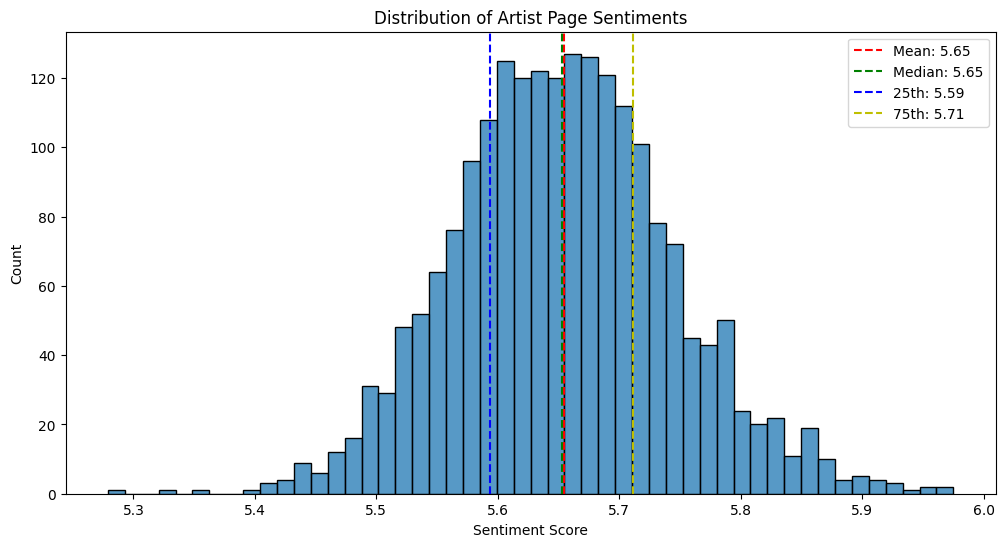

In [111]:
plt.figure(figsize=(12, 6))
sns.histplot(sentiments, bins=50)
plt.axvline(stats['mean'], color='r', linestyle='--', label=f"Mean: {stats['mean']:.2f}")
plt.axvline(stats['median'], color='g', linestyle='--', label=f"Median: {stats['median']:.2f}")
plt.axvline(stats['25th'], color='b', linestyle='--', label=f"25th: {stats['25th']:.2f}")
plt.axvline(stats['75th'], color='y', linestyle='--', label=f"75th: {stats['75th']:.2f}")
plt.title('Distribution of Artist Page Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend()
plt.show()

We see that the sentiment distribution follows a bell curve that is (mostly) symmetrical around the middle. Based on the visualization, we have reason to believe that all the artists more or less share the same general sentiment, but with natural variance (super happy or super sad artists do not appear more frequently that expected).
  
In terms of simply summary statistics, the mean is 5.654, the median is 5.653 and the standard deviation is 0.091.

### Part 3B: Sentiment Analysis of Largest Communities
> * Discuss the sentiment of the largest communities. Do the findings using TF-IDF help you understand your results?  
  
Now we'll analyze the sentiment distribution across different communities in the network.  
  
We will start off by loading the genres data for each artist (credit to Aliaksandr)

In [ ]:
with open('w7_data.txt', 'r') as f:  #file uploaded by TA Aliaksandr
    genre_data = json.load(f)

def get_all_genres(genre_data):
    genre_communities = {}
    for artist, genres in genre_data.items():
        for genre in genres:
            if genre not in genre_communities:
                genre_communities[genre] = []
            genre_communities[genre].append(artist)
    #to only get the largest communities, we filter out genres with fewer than 80 artists
    filtered_genre_communities = {genre: artists for genre, artists in genre_communities.items()
                                if len(artists) >= 80}
    return filtered_genre_communities
genre_communities = get_all_genres(genre_data)

def clean_artist_name(raw_name):  #ensure the key name matches the formatting used by Aliaksandr
    name = re.sub(r'\(.*?\)', '', raw_name)
    name = name.split(" (")[0]
    name = name.split('|')[0]
    name = name.replace('_', ' ').strip()
    return name
cleaned_artist_sentiments = {clean_artist_name(key): value for key, value in artist_sentiments.items()}
cleaned_artist_texts = {clean_artist_name(key): value for key, value in artist_texts.items()}

Note that we have filtered out genres with fewer than 80 artist. This is done to only focus on the largest communities.  
  
We now calculate the sentiment for each genre community.

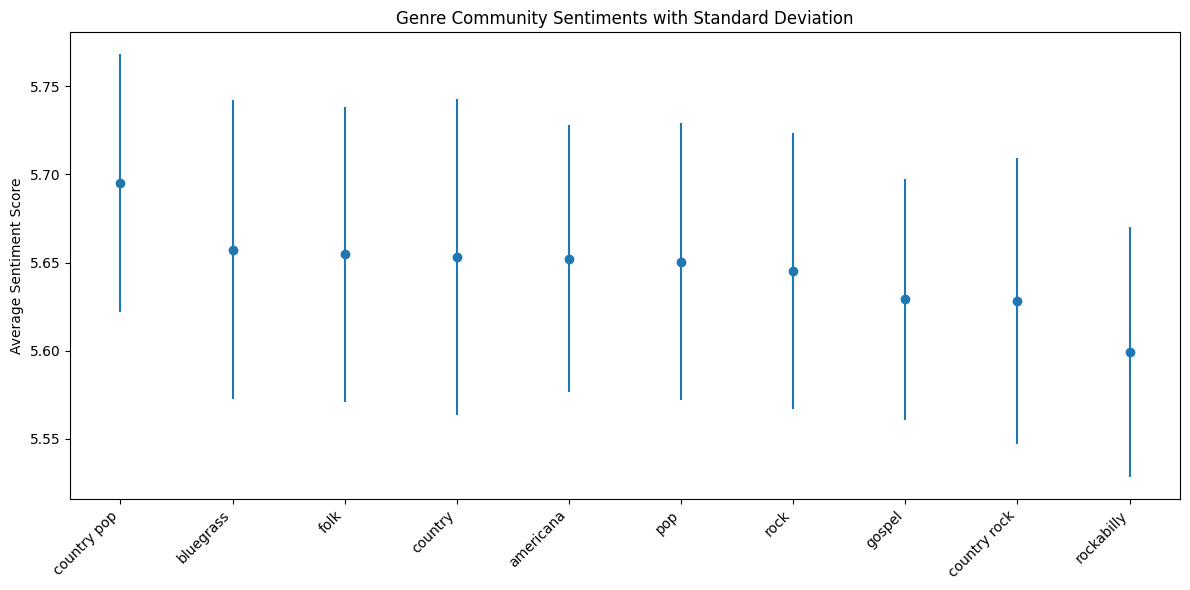


Genre Community Sentiments:
country pop: 5.695 (±0.073), size: 109
bluegrass: 5.657 (±0.085), size: 126
folk: 5.655 (±0.084), size: 174
country: 5.653 (±0.090), size: 1479
americana: 5.652 (±0.076), size: 153
pop: 5.650 (±0.078), size: 154
rock: 5.645 (±0.078), size: 115
gospel: 5.629 (±0.068), size: 94
country rock: 5.628 (±0.081), size: 165
rockabilly: 5.599 (±0.071), size: 79


In [359]:
import numpy as np
genre_sentiments = {}
for genre, artists in genre_communities.items():
    genre_scores = [cleaned_artist_sentiments[clean_artist_name(artist)]
                    for artist in artists if clean_artist_name(artist) in cleaned_artist_sentiments]
    if genre_scores:
        genre_sentiments[genre] = {
            'sentiment': np.mean(genre_scores),  #average sentiment score
            'size': len(genre_scores),           #number of artists with sentiment scores
            'std': np.std(genre_scores)          #standard deviation of the sentiment scores
        }

sorted_genres = sorted(genre_sentiments.items(),
                       key=lambda x: x[1]['sentiment'],
                       reverse=True)
plt.figure(figsize=(12, 6))
genres = [g[0] for g in sorted_genres]
sentiments = [g[1]['sentiment'] for g in sorted_genres]
errors = [g[1]['std'] for g in sorted_genres]
plt.errorbar(range(len(genres)), sentiments, yerr=errors, fmt='o')
plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
plt.title('Genre Community Sentiments with Standard Deviation')
plt.ylabel('Average Sentiment Score')
plt.tight_layout()
plt.show()
print("\nGenre Community Sentiments:")
for genre, stats in sorted_genres:
    print(f"{genre}: {stats['sentiment']:.3f} (±{stats['std']:.3f}), size: {stats['size']}")



Above we can see a comparison between the sentiment of the 10 biggest communities. Country pop has the highest sentiment, whereas rockabilly has the lowest sentiment. However the difference is somewhat small and not significant.   
  
We will now do TF-IDF analysis to get a deeper understanding.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
custom_stop_words = [  #we define a custom set of stop words that are frequent but not meaningful
    'ref', 'date', 'com', 'url', 'title', 'web', 'cite',
    'www', 'http', 'https', 'archive', 'width', 'align',
    'center', 'scope', '01', 'album', 'band', 'english',
    'access', 'category', 'org',
]

genre_texts = {}  # Combine texts for each genre
for genre, artists in genre_communities.items():
    texts = [cleaned_artist_texts[clean_artist_name(artist)] for artist in artists if clean_artist_name(artist) in cleaned_artist_texts]
    genre_texts[genre] = ' '.join(texts)
vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stop_words)
tfidf_matrix = vectorizer.fit_transform(genre_texts.values())
feature_names = vectorizer.get_feature_names_out()

for genre, text_idx in zip(genre_texts.keys(), range(len(genre_texts))):
    tfidf_scores = tfidf_matrix[text_idx].toarray()[0]
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"Top terms for {genre}:")
    print(', '.join(top_terms))

Top terms for country:
the, and, of, in, country, to, music, on, name, was, with, for, u2014, his, first, style, at, billboard, news, he
Top terms for country rock:
the, and, of, in, to, country, music, on, was, with, name, for, news, first, his, at, from, as, billboard, magazine
Top terms for folk:
the, and, of, in, to, music, on, name, with, was, for, country, first, his, u2014, at, news, magazine, as, he
Top terms for gospel:
the, of, and, in, to, music, country, on, was, with, for, name, his, at, he, first, her, as, news, by
Top terms for pop:
the, and, of, in, to, music, on, news, for, with, name, was, first, magazine, billboard, status, country, her, live, last
Top terms for bluegrass:
the, of, and, in, to, music, name, country, on, with, for, was, bluegrass, at, as, first, from, his, year, by
Top terms for rock:
the, and, of, in, to, music, on, with, name, for, was, first, news, magazine, his, last, style, as, billboard, at
Top terms for rockabilly:
the, and, of, in, to, was, on

*Discussion*  
  
The TF-IDF results show overlap in common terms ("the", "of", "and", "in") across genres, this is to be expected.  
    
The more traditional genres (Rockabilly, Gospel, Country Rock) have slightly lower sentiment scores than the commercially successful genres (Country Pop, Pop, Rock), which may be due to the emotion surrounding the artist and the music.  
  
However, we can see that the sentiment is overall positive for all the genres and the differences between genres are relatively small (range from 5.599 to 5.695). So this difference is mostly nitpicking, and with such a small difference in sentiment we shouldn't expect a big difference in the sentiment of the most common words.  

Finally, it should be noted that we needed to set up a word filter to filter out words such as 'www', 'http' and 'ref'. If we did not do this, the top terms would be wikitext syntax and similar web keywords. This means that we did not properly clean the data before running our analysis, which may have impacted the results.